# Module 1.3: Tool Calling Agent with LangGraph

![Tool calling](https://github.com/IT-HUSET/ai-agenter-2025/blob/main/images/tool-calling.png?raw=true)

**Objective:** Build a real ReAct agent with tool calling capabilities

In this exercise, you'll learn:
- Defining tools using `@tool` decorator
- Binding tools to LLM with `bind_tools()`
- Using `ToolNode` for automatic tool execution
- Implementing `tools_condition` for routing
- Building a complete ReAct loop

<a target="_blank" href="https://githubtocolab.com/IT-HUSET/ai-agenter-2025/blob/main/exercises/langgraph/1.3-langgraph-tool-calling.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

---

## Setup

### Install dependencies

In [ ]:
%pip install openai~=2.0 --upgrade --quiet
%pip install python-dotenv~=1.0 --upgrade --quiet
%pip install langchain~=0.3 langchain_openai~=0.3 --upgrade --quiet
%pip install langgraph~=0.6 --upgrade --quiet

### Load environment variables

In [2]:
import os

# Check if running in Google Colab
try:
    from google.colab import userdata
    IN_COLAB = True
    # Get API key from Colab secrets
    os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    print("✅ Running in Google Colab - API key loaded from secrets")
except ImportError:
    IN_COLAB = False
    # Load from .env file for local development
    try:
        from dotenv import load_dotenv, find_dotenv
        load_dotenv(find_dotenv())
        print("✅ Running locally - API key loaded from .env file")
    except ImportError:
        print("⚠️ python-dotenv not installed. Install with: pip install python-dotenv")

# Verify API key is set
if not os.environ.get("OPENAI_API_KEY"):
    print("❌ OPENAI_API_KEY not found!")
    if IN_COLAB:
        print("   → Click the key icon (🔑) in the left sidebar")
        print("   → Add a secret named 'OPENAI_API_KEY'")
        print("   → Toggle 'Notebook access' to enable it")
    else:
        print("   → Create a .env file with: OPENAI_API_KEY=your-key-here")
else:
    print("✅ API key configured!")

✅ Running locally - API key loaded from .env file
✅ API key configured!


### Setup LLM

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

---

## Part 1: Define Tools

### What are Tools?

Tools are functions that an agent can call to:
- Access external data (APIs, databases)
- Perform calculations
- Execute actions (send email, create file)
- Interact with systems

### The `@tool` Decorator

LangChain provides a `@tool` decorator that:
1. Converts a Python function into a tool
2. Generates a JSON schema from docstring and type hints
3. Makes the tool compatible with LLM function calling

In [4]:
from langchain_core.tools import tool
from typing import Literal
import random

@tool
def get_weather(city: str) -> str:
    """Get the current weather for a city.
    
    Args:
        city: The name of the city to get weather for
        
    Returns:
        A string describing the current weather
    """
    print(f"🌤️  Calling weather API for: {city}")
    
    # Simulated weather data
    weather_data = {
        "stockholm": "5°C, cloudy with a chance of meatballs",
        "london": "12°C, rainy (as usual)",
        "tokyo": "18°C, clear skies",
        "new york": "8°C, windy",
        "sydney": "25°C, sunny"
    }
    
    city_lower = city.lower()
    if city_lower in weather_data:
        return f"The weather in {city} is: {weather_data[city_lower]}"
    else:
        return f"Weather data not available for {city}. Try Stockholm, London, Tokyo, New York, or Sydney."


@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression.
    
    Args:
        expression: A mathematical expression as a string (e.g., "2 + 2", "10 * 5")
        
    Returns:
        The result of the calculation as a string
    """
    print(f"🔢 Calculating: {expression}")
    
    try:
        # Safe evaluation (restricted to basic math)
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error calculating '{expression}': {str(e)}"


@tool
def get_random_fact(topic: Literal["space", "ocean", "animals", "history"]) -> str:
    """Get a random interesting fact about a topic.
    
    Args:
        topic: The topic to get a fact about (space, ocean, animals, or history)
        
    Returns:
        An interesting fact as a string
    """
    print(f"📚 Fetching random fact about: {topic}")
    
    facts = {
        "space": [
            "A day on Venus is longer than a year on Venus.",
            "Neutron stars are so dense that a teaspoon would weigh billions of tons.",
            "There are more stars in the universe than grains of sand on all Earth's beaches."
        ],
        "ocean": [
            "The ocean produces more than 50% of the world's oxygen.",
            "The deepest part of the ocean is nearly 7 miles down.",
            "More people have been to the moon than to the deepest part of the ocean."
        ],
        "animals": [
            "Octopuses have three hearts and blue blood.",
            "A group of flamingos is called a 'flamboyance'.",
            "Honey never spoils. Archaeologists have found 3000-year-old honey that's still edible."
        ],
        "history": [
            "Cleopatra lived closer to the Moon landing than to the building of the pyramids.",
            "Oxford University is older than the Aztec Empire.",
            "The first programmer was Ada Lovelace in the 1840s."
        ]
    }
    
    return random.choice(facts[topic])

### Test Tools Independently

In [5]:
# Test weather tool
print(get_weather.invoke("Stockholm"))
print()

# Test calculator
print(calculate.invoke("42 * 17"))
print()

# Test fact tool
print(get_random_fact.invoke("space"))

🌤️  Calling weather API for: Stockholm
The weather in Stockholm is: 5°C, cloudy with a chance of meatballs

🔢 Calculating: 42 * 17
The result of 42 * 17 is 714

📚 Fetching random fact about: space
A day on Venus is longer than a year on Venus.


### Inspect Tool Schema

See how LangChain converts your function into a tool schema:

In [6]:
import json

print("Weather Tool Schema:")
print(json.dumps(get_weather.args_schema.schema(), indent=2))

Weather Tool Schema:
{
  "description": "Get the current weather for a city.\n\nArgs:\n    city: The name of the city to get weather for\n\nReturns:\n    A string describing the current weather",
  "properties": {
    "city": {
      "title": "City",
      "type": "string"
    }
  },
  "required": [
    "city"
  ],
  "title": "get_weather",
  "type": "object"
}


/var/folders/0z/sc5m58852p5g4hzfmy4dmpqm0000gn/T/ipykernel_54324/2761050928.py:4: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  print(json.dumps(get_weather.args_schema.schema(), indent=2))


## Part 2: Build Tool-Calling Agent with create_react_agent

### The ReAct Pattern

**ReAct** = **Rea**soning + **Act**ing

The agent follows this loop:
1. **Think**: Decide what to do based on the question
2. **Act**: Call a tool if needed
3. **Observe**: See the tool's result
4. **Repeat** or **Answer**: Continue until done

### Using create_react_agent

Instead of manually building the graph, LangGraph provides `create_react_agent` which:
- Automatically binds tools to the LLM
- Creates the tool execution node
- Sets up the conditional routing logic
- Handles the ReAct loop

This is much simpler than building everything from scratch!

✅ Created ReAct agent with 3 tools
   Tools: ['get_weather', 'calculate', 'get_random_fact']


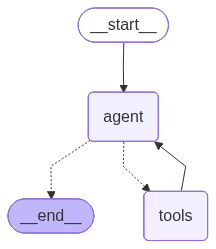

In [7]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# Collect all tools
tools = [get_weather, calculate, get_random_fact]

# Create the agent - that's it! 
agent = create_react_agent(
    model=llm,
    tools=tools,
    prompt="You are a helpful assistant with access to tools. Use them when needed to provide accurate information."
)

print(f"✅ Created ReAct agent with {len(tools)} tools")
print(f"   Tools: {[t.name for t in tools]}")

# Visualize the graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### What create_react_agent Does for You

Behind the scenes, `create_react_agent`:

1. **Binds tools to LLM** - Calls `llm.bind_tools(tools)` automatically
2. **Creates agent node** - Sets up the node that calls the LLM
3. **Creates ToolNode** - Sets up automatic tool execution
4. **Adds conditional routing** - Uses `tools_condition` to route between agent and tools
5. **Builds the graph** - Constructs and compiles the complete StateGraph

This is the same as what we did manually in Module 1.2, but much simpler!

---

## Part 3: Test the Agent

### Single Tool Call Test

In [8]:
from langchain_core.messages import HumanMessage

# Simple question requiring one tool
question = "What's the weather like in Stockholm?"

print(f"❓ Question: {question}")
print("="*80)

result = agent.invoke({
    "messages": [HumanMessage(content=question)]
})

# Print the conversation
print("\n💬 Conversation:")
for msg in result["messages"]:
    msg.pretty_print()

❓ Question: What's the weather like in Stockholm?
🌤️  Calling weather API for: Stockholm

💬 Conversation:
================================ Human Message =================================

What's the weather like in Stockholm?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_foXnf81wEhfx7QIPlFYJc4RA)
 Call ID: call_foXnf81wEhfx7QIPlFYJc4RA
  Args:
    city: Stockholm
================================= Tool Message =================================
Name: get_weather

The weather in Stockholm is: 5°C, cloudy with a chance of meatballs
================================== Ai Message ==================================

The weather in Stockholm is currently 5°C, cloudy with a chance of meatballs!


### Multiple Tool Calls Test

In [9]:
# Complex question requiring multiple tools
question = "Calculate 123 * 456 and also tell me the weather in Tokyo"

print(f"❓ Question: {question}")
print("="*80)

result = agent.invoke({
    "messages": [HumanMessage(content=question)]
})

print("\n💬 Conversation:")
for msg in result["messages"]:
    msg.pretty_print()

❓ Question: Calculate 123 * 456 and also tell me the weather in Tokyo
🔢 Calculating: 123 * 456🌤️  Calling weather API for: Tokyo


💬 Conversation:
================================ Human Message =================================

Calculate 123 * 456 and also tell me the weather in Tokyo
================================== Ai Message ==================================
Tool Calls:
  calculate (call_6vxbUV38JnmL1dIsRVrFZOVl)
 Call ID: call_6vxbUV38JnmL1dIsRVrFZOVl
  Args:
    expression: 123 * 456
  get_weather (call_15w2QebSpKlEMa5Ir6X4y7EW)
 Call ID: call_15w2QebSpKlEMa5Ir6X4y7EW
  Args:
    city: Tokyo
================================= Tool Message =================================
Name: calculate

The result of 123 * 456 is 56088
================================= Tool Message =================================
Name: get_weather

The weather in Tokyo is: 18°C, clear skies
================================== Ai Message ==================================

The result of \( 123 \times 456 \) i

### Chain of Tool Calls Test

Test if the agent can use tool results to make follow-up tool calls:

In [10]:
# Question that requires sequential reasoning
question = """Calculate 15 * 8, then tell me if that number is greater than 100. 
If it is, give me a space fact. If not, give me an ocean fact."""

print(f"❓ Question: {question}")
print("="*80)

result = agent.invoke({
    "messages": [HumanMessage(content=question)]
})

print("\n💬 Final Answer:")
result["messages"][-1].pretty_print()

❓ Question: Calculate 15 * 8, then tell me if that number is greater than 100. 
If it is, give me a space fact. If not, give me an ocean fact.
🔢 Calculating: 15 * 8
📚 Fetching random fact about: space

💬 Final Answer:
================================== Ai Message ==================================

The result of \( 15 \times 8 \) is 120, which is greater than 100. 

Here's a space fact: A day on Venus is longer than a year on Venus.


### Stream the Execution

See the agent's thought process in real-time:

In [11]:
question = "What's the weather in London and give me a history fact"

print(f"❓ Question: {question}")
print("="*80)
print("\n🔄 Streaming execution:\n")

for step in agent.stream({"messages": [HumanMessage(content=question)]}):
    print(f"Step: {list(step.keys())[0]}")
    print(f"  Content: {step}")
    print()

❓ Question: What's the weather in London and give me a history fact

🔄 Streaming execution:

Step: agent
  Content: {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_D04fsMljP7Q2lTG7jNFxx9IL', 'function': {'arguments': '{"city": "London"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_BztCEYOTSd6fTIETyWjynd6R', 'function': {'arguments': '{"topic": "history"}', 'name': 'get_random_fact'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 224, 'total_tokens': 269, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-COievoLrT11pk5mkG4bqdzI9Cg4mO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 

---

## 🎯 Exercise: Build a Research Assistant Agent

**Challenge:** Create a research assistant using `create_react_agent`.

### Requirements:

1. **Create these tools**:
   - `search_wikipedia(topic: str)` - Simulate Wikipedia search
   - `get_current_date()` - Return today's date
   - `convert_currency(amount: float, from_currency: str, to_currency: str)` - Currency conversion

2. **Build the agent** using `create_react_agent` - just like we did above!

3. **Test with complex queries**:
   - "What year was Python created and how many years ago was that?"
   - "Convert 100 USD to EUR and then to JPY"

### Template

In [12]:
from datetime import datetime

# TODO: Define your tools here
@tool
def search_wikipedia(topic: str) -> str:
    """Search Wikipedia for information about a topic.
    
    Args:
        topic: The topic to search for
    """
    # TODO: Implement simulated Wikipedia search
    wiki_data = {
        "python": "Python was created by Guido van Rossum and first released in 1991.",
        "langchain": "LangChain is a framework for developing LLM applications, created in 2022.",
        # Add more topics...
    }
    return wiki_data.get(topic.lower(), f"No information found for {topic}")

@tool
def get_current_date() -> str:
    """Get the current date."""
    # TODO: Return current date in readable format
    return datetime.now().strftime("%Y-%m-%d")

@tool
def convert_currency(amount: float, from_currency: str, to_currency: str) -> str:
    """Convert currency from one type to another.
    
    Args:
        amount: The amount to convert
        from_currency: Source currency (USD, EUR, JPY, etc.)
        to_currency: Target currency (USD, EUR, JPY, etc.)
    """
    # TODO: Implement simulated currency conversion
    rates = {
        ("USD", "EUR"): 0.92,
        ("EUR", "USD"): 1.09,
        ("USD", "JPY"): 149.50,
        ("JPY", "USD"): 0.0067,
        ("EUR", "JPY"): 162.50,
        ("JPY", "EUR"): 0.0062,
    }
    
    pair = (from_currency.upper(), to_currency.upper())
    if pair in rates:
        result = amount * rates[pair]
        return f"{amount} {from_currency} = {result:.2f} {to_currency}"
    return f"Conversion rate not available for {from_currency} to {to_currency}"

# TODO: Create the agent using create_react_agent
# research_tools = [search_wikipedia, get_current_date, convert_currency]
# research_agent = create_react_agent(
#     model=llm,
#     tools=research_tools,
#     prompt="You are a research assistant..."
# )

# TODO: Test with complex queries
# result = research_agent.invoke({
#     "messages": [HumanMessage(content="What year was Python created and how many years ago was that?")]
# })
# result["messages"][-1].pretty_print()

---

## Key Takeaways

✅ **Tool Definition**: Use `@tool` decorator for automatic schema generation  
✅ **create_react_agent**: Simplifies agent creation with automatic setup  
✅ **ReAct Pattern**: Think → Act → Observe → Repeat  
✅ **Simple API**: Just pass model, tools, and prompt to `create_react_agent`  
✅ **Streaming Support**: Use `.stream()` to see execution in real-time  

### Best Practices for Tool-Calling Agents

**Tool Design:**
- Clear, descriptive docstrings (LLM reads these!)
- Type hints for all parameters
- Meaningful parameter names
- Handle errors gracefully
- Return strings (easiest for LLM to process)

**Agent Design:**
- Use descriptive prompts to guide agent behavior
- Start simple with a few tools
- Test tools independently first
- Use streaming to debug agent reasoning

**Debugging:**
- Stream execution to see each step
- Check tool schemas with `.args_schema.schema()`
- Use `xray=True` in graph visualization
- Test with increasingly complex queries

### Common Pitfalls

❌ **Poor docstrings** → LLM doesn't know when to use tool  
❌ **Complex return types** → LLM can't interpret results  
❌ **No error handling** → Agent gets stuck on failures  
❌ **Too many tools** → LLM gets confused about which to use  
❌ **Vague tool names** → LLM calls wrong tool  

### Benefits of create_react_agent vs Manual Construction

**create_react_agent** (Recommended):
- ✅ Less boilerplate code
- ✅ Automatically handles common patterns
- ✅ Easier to maintain
- ✅ Best for most use cases

**Manual Construction** (Advanced):
- Use when you need custom node logic
- Use when you need non-standard routing
- Use when you need to customize the state schema

### Next Steps

- Explore more complex tool combinations
- Add memory and persistence to your agents
- Learn about multi-agent systems
- Build production-ready agents with error handling

---

## Additional Resources

- [LangGraph create_react_agent Guide](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/)
- [LangGraph Agents Overview](https://langchain-ai.github.io/langgraph/agents/agents/)
- [LangChain Tools Documentation](https://python.langchain.com/docs/concepts/tools/)
- [ReAct Paper (2022)](https://arxiv.org/abs/2210.03629)